In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

%matplotlib inlineimport torch
import os
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
# from tqdm import tqdm
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
batch_size = 64
epoch = 500
INPUT_SIZE = 224
num_workers = 20
device = torch.device("cuda")

In [3]:
DATA_DIR = "../ssd/images/"
image_names = os.listdir(DATA_DIR)

# print(type(image_names))
# print(len(image_names))


# image_path = os.path.join(DATA_DIR,image_names[0])
# im = Image.open(image_path)
# im.size

In [4]:
class MODEL(nn.Module):
    def __init__(self):
        super(MODEL,self).__init__()
        self.conv1 = nn.Conv2d(3,16,7,stride=2)     #16*109*109
        self.conv2 = nn.Conv2d(16,32,7,stride=2)    #32*52*52
        self.conv3 = nn.Conv2d(32,64,7,stride=2)    #64*23*23
        self.conv4 = nn.Conv2d(64,128,7,stride=2)   #128*9*9
        self.conv5 = nn.Conv2d(128,256,3,stride=2)  #256*4*4
        self.lineartohidden = nn.Linear(4096,256)
        self.hiddentolinear = nn.Linear(256,4096)                            
        self.deconv5 = nn.ConvTranspose2d(256,128,3,stride=2)                #128*9*9
        self.deconv4 = nn.ConvTranspose2d(128,64,7,stride=2)                 #64*23*23
        self.deconv3 = nn.ConvTranspose2d(64,32,7,stride=2,output_padding=1) #32*52*52
        self.deconv2 = nn.ConvTranspose2d(32,16,7,stride=2)                  #16*109*109 
        self.deconv1 = nn.ConvTranspose2d(16,3,7,stride=2,output_padding=1)  #3*224*224
         
    def forward(self,x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = x.view(-1,self.num_flat_features(x))
        x = F.elu(self.lineartohidden(x))
        feature = x
        x = F.elu(self.hiddentolinear(x))
        x = x.view(-1,256,4,4)
        x = F.elu(self.deconv5(x))
        x = F.elu(self.deconv4(x))
        x = F.elu(self.deconv3(x))
        x = F.elu(self.deconv2(x))
        x = self.deconv1(x)
        
        return x,feature
        
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
MODEL()
        

MODEL(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (lineartohidden): Linear(in_features=4096, out_features=256, bias=True)
  (hiddentolinear): Linear(in_features=256, out_features=4096, bias=True)
  (deconv5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2))
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(2, 2), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(2, 2))
  (deconv1): ConvTranspose2d(16, 3, kernel_size=(7, 7), stride=(2, 2), output_padding=(1, 1))
)

In [5]:
class MyDataSet(Dataset):
    def __init__(self,image_dir,transform_input,transform_target):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)[:5000]
        self.len = len(self.image_list)
        print("dataset_len",self.len)
#         self.len = 5000
        self.transform_input = transform_input
        self.transform_target = transform_target
    def __len__(self):
        return self.len
    def __getitem__(self,idx):
        image_path = os.path.join(self.image_dir,self.image_list[idx])
        im = Image.open(image_path)
        return (self.transform_input(im),self.transform_target(im),self.image_list[idx])

In [6]:
transform_input = transforms.Compose([transforms.Resize((INPUT_SIZE,INPUT_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_target = transforms.Compose([transforms.Resize((INPUT_SIZE,INPUT_SIZE)),
                                transforms.ToTensor()])
my_dataset = MyDataSet(DATA_DIR,transform_input=transform_input,transform_target=transform_target)
dataset_loader = torch.utils.data.DataLoader(my_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)
embedding_loader = torch.utils.data.DataLoader(my_dataset,batch_size=1,shuffle=False,num_workers=num_workers)

('dataset_len', 5000)


In [7]:
model = MODEL()


In [16]:
global_lr = 0.001
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(),lr=global_lr,momentum=0.9,nesterov=True)
optimizer = optim.Adam(model.parameters(),lr=global_lr)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

3750467

In [17]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = global_lr * (0.1 ** (epoch // 5))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [18]:
def train():
    model.load_state_dict(torch.load("./model_adam_256_ELU1.pkl"))
    model.train()
    for e in range(epoch):
        loss_sum = 0
        for i,batch in enumerate(dataset_loader):
            batch,target,_ = batch
            optimizer.zero_grad()
            output,_ = model(batch.cuda())
            loss = criterion(output,target.cuda())
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
#         print("lr= ",adjust_learning_rate(optimizer,e))
            
        print("epoch %d loss %f"%(e,loss_sum))
        if e%5==0:
            torch.save(model.state_dict(), "./model_adam_256_ELU2.pkl")

In [20]:
model.cuda()
train()

In [26]:
emb = {}
model.cuda()
model.load_state_dict(torch.load("./model_adam_1.pkl"))
def test():
    model.eval()
    with torch.no_grad():
        for i,batch in enumerate(embedding_loader):
            batch,target,image_names= batch
            output,embedding = model(batch.cuda())
            img = output.cpu().numpy().squeeze(0)
            plt.imshow(target.numpy().squeeze(0).transpose(1,2,0))
            plt.show()
            print(img.shape)
            img = img.transpose(1,2,0)
            plt.imshow(img)
            plt.show()
            if i==5:
                break
            embedding = embedding.cpu().numpy()
            emb[image_names]= embedding
            
        torch.save(emb,"./embeddings.pt")


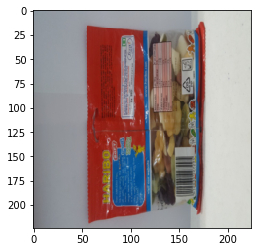

(3, 224, 224)


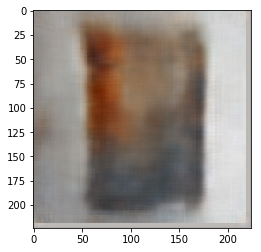

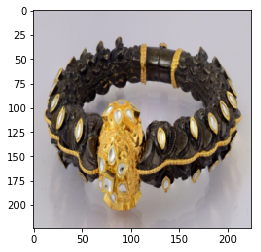

(3, 224, 224)


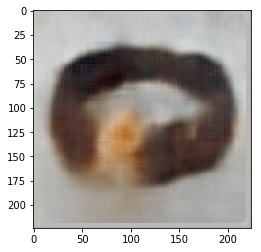

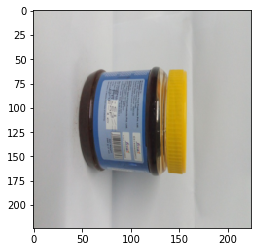

(3, 224, 224)


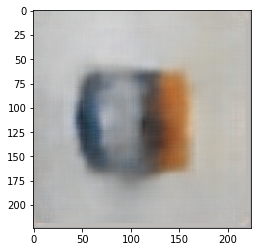

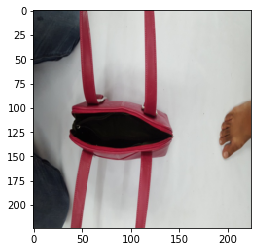

(3, 224, 224)


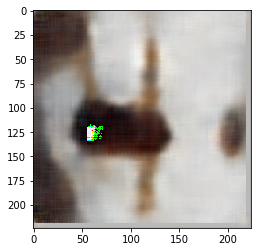

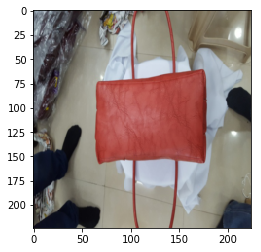

(3, 224, 224)


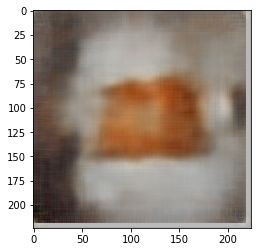

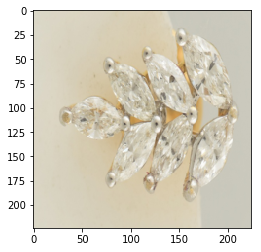

(3, 224, 224)


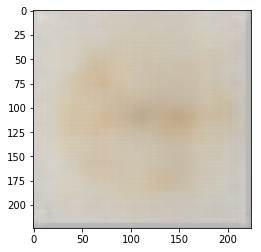

In [27]:
test()

In [59]:
len(emb)

0